## Only upsampling Test data 

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
plt.rcParams['font.size'] = 14
plt.style.use('seaborn-whitegrid')

In [3]:
df = pd.read_csv('cleaned_data/Cleaned Data.csv',index_col=[0])

In [4]:
df['Signal'].value_counts()

Sell    6153
Buy     4681
Hold     745
Name: Signal, dtype: int64

In [5]:
SignalFac = []

for string in df['Signal']:
    if string == 'Sell':
        SignalFac.append(2)
    elif string == 'Hold':
        SignalFac.append(1)    
    else:
        SignalFac.append(0)

In [6]:
df['SignalFac'] = SignalFac

In [7]:
y = df['SignalFac']
X = df.drop(['Signal','SignalFac'], axis=1)

In [8]:
# Create Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [9]:
print('Sell hat', X_train[y_train==2].shape[0], 'Werte')
print('Hold hat', X_train[y_train==1].shape[0], 'Werte')
print('Buy hat', X_train[y_train==0].shape[0], 'Werte')

Sell hat 4307 Werte
Hold hat 521 Werte
Buy hat 3277 Werte


In [10]:
#Upsampling of Hold to the number of Sell

from sklearn.utils import resample

X_upsampled, y_upsampled = resample(X_train[y_train==1], y_train[y_train==1],
                                    replace=True,
                                    n_samples=3786,
                                    random_state=1)

In [11]:
# Combine datasets
X_bal = np.vstack((X_train, X_upsampled))
y_bal = np.hstack((y_train, y_upsampled))

In [12]:
#Upsampling of Buy to the number of Sells

from sklearn.utils import resample

X2_upsampled, y2_upsampled = resample(X_train[y_train==0], y_train[y_train==0],
                                    replace=True,
                                    n_samples=1030,
                                    random_state=1)

In [13]:
# Combine datasets
X_bal = np.vstack((X_bal, X2_upsampled))
y_bal = np.hstack((y_bal, y2_upsampled))

In [14]:
pd.value_counts(pd.DataFrame(y_bal)[0])

2    4307
1    4307
0    4307
Name: 0, dtype: int64

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Create classifier object and fit it to data
forest = RandomForestClassifier(criterion='gini', random_state=0, n_jobs=-1)
forest.fit(X_bal, y_bal)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [16]:
y_pred = forest.predict(X_test)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.49      0.47      0.48      1404
           1       0.06      0.01      0.02       224
           2       0.59      0.67      0.63      1846

    accuracy                           0.55      3474
   macro avg       0.38      0.38      0.38      3474
weighted avg       0.52      0.55      0.53      3474



In [18]:
print('Confusion matrix: \n', 
      metrics.confusion_matrix(y_test,y_pred))

Confusion matrix: 
 [[ 661   17  726]
 [  87    2  135]
 [ 594   12 1240]]


## Redo following steps: PCA & CV

Only PCA Features

In [20]:
from sklearn.decomposition import PCA

# Define no. of PC
q = 10

# Create PCA object and fit to find  
# first q principal components
pca = PCA(n_components=q)
pca.fit(X_train)
pca

PCA(n_components=10)

In [21]:
# Run PCA for all possible PCs
pca = PCA().fit(X_train)

# Define max no. of PC
q = X_train.shape[1]

# Get cumsum of the PC 1-q
expl_var = pca.explained_variance_ratio_
sum_expl_var = np.cumsum(expl_var)[:q]

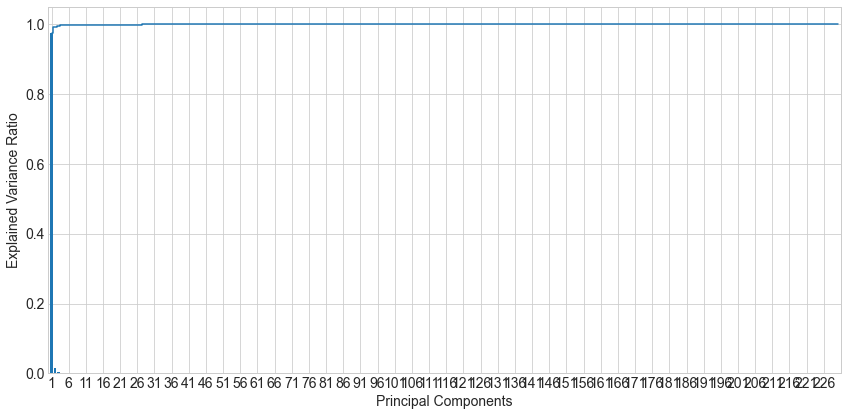

In [46]:
# Plot Feature Importance (both cumul., individual)
plt.figure(figsize=(12, 6))
plt.bar(range(1, q + 1), expl_var, align='center')
plt.xticks(range(1, q + 1, 5))
plt.xlim([0, q + 1])
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.step(range(1, 1 + q), sum_expl_var, where='mid')
plt.tight_layout();

In [47]:
# PCA Feature Selection approach
from sklearn.decomposition import PCA

In [48]:
#Create Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [49]:
pca = PCA(n_components=10)
pca.fit(X_train)

PCA(n_components=10)

In [50]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 

In [51]:
from sklearn.ensemble import RandomForestClassifier

# Create classifier object and fit it to data
forest = RandomForestClassifier(criterion='gini', random_state=0, n_jobs=-1)
forest.fit(X_train_pca, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [53]:
y_pred = forest.predict(X_test_pca)

In [54]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.48      0.43      0.45      1404
           1       0.09      0.01      0.02       224
           2       0.58      0.69      0.63      1846

    accuracy                           0.54      3474
   macro avg       0.38      0.38      0.37      3474
weighted avg       0.51      0.54      0.52      3474



Cross Validation

In [55]:
# Create Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [56]:
# Import necessary functions
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Create k-Fold CV and LogReg object
kFold = StratifiedKFold(n_splits=5)
forestcv = RandomForestClassifier(criterion='gini', random_state=0, n_jobs=-1)

# Run CV and print results
scores = cross_val_score(forestcv, X_train, y_train, cv=kFold)
print(scores)
print('CV accuracy on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))

[0.57310302 0.57495373 0.57618754 0.56014806 0.57680444]
CV accuracy on train set:  0.572 +/-  0.006


In [57]:
print('Test set accuracy:            ', forestcv.fit(X_train, y_train).score(X_test, y_test))

Test set accuracy:             0.5667818077144502


In [58]:
#No additional improvement